# Offline training of boat agent 

Generate trajectories of an optimal boat agent.

Pretrain RL agent 1 on this offline data
Continue train RL agent 1 online on environment
Train RL agent 2 online on environment.

Compare rewards per epoch of post-pretraining.



In [4]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [5]:
def get_bearing(vector):
    x1, y1 = 0,0
    x2, y2 = vector

    # Calculate the angle from the positive x-axis to the line connecting the points
    angle_rad = np.arctan2(y2 - y1, x2 - x1)

    # Convert the angle from radians to degrees
    angle_deg = np.degrees(angle_rad)

    # Convert to bearing by measuring clockwise from North
    bearing = (90 - angle_deg + 360) % 360

    return bearing
get_bearing((1,1))

45.0

In [6]:
def get_vector(bearing, length):
    # Convert bearing to angle measured counterclockwise from the positive x-axis
    angle = (90 - bearing) % 360
    
    # Compute x and y components using cosine and sine
    x = length * np.cos(np.radians(angle))
    y = length * np.sin(np.radians(angle))
    
    return np.array([x, y])

get_vector(-45, 1).round(1)


array([-0.7,  0.7])

In [7]:
def get_distance(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    p1 = np.array([x1, y1])
    p2 = np.array([x2, y2])

    return np.linalg.norm(p2 - p1)
get_distance((0,0), (3,4))

5.0

In [153]:
class MotorboatEnv(gym.Env):
    def __init__(self):
        super().__init__()

        # Action space: throttle [-1, 1], steer [-30, 30]
        self.action_space = spaces.Box(low=np.array([-1, -30]), high=np.array([1, 30]), dtype=np.float32)
        
        # Observation space: boat x, y, target x, y, current vector x, y, boat heading
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(8,), dtype=np.float32)

        # Parameters
        self.max_timesteps = 1000
        self.current_strength = 0.1
        self.target_position = np.array([0.0, 0.0])

        self.reset()
    
    def _get_observation(self):
        current_vector = get_vector(self.current_heading, self.current_strength)
        observation = np.array([
            self.boat_position[0],  # boat x
            self.boat_position[1],  # boat y
            self.target_position[0],  # target x
            self.target_position[1],  # target y
            current_vector[0],  # current x
            current_vector[1],  # current y
            self.boat_heading  # boat heading
        ])
        return observation
    
    def step(self, action):
        # Extract and truncate actions
        throttle, steer = np.clip(action, [-1, -30], [1, 30])

        # Change heading of boat
        self.boat_heading = (self.boat_heading + steer) % 360

        # Compute velocity due to throttle
        boat_velocity = get_vector(self.boat_heading, throttle)
        
        # Compute velocity due to current
        current_velocity = get_vector(self.current_heading, self.current_strength)
        
        # Update boat position
        self.boat_position += boat_velocity + current_velocity

        # Compute distance to target
        distance_to_target = get_distance(self.boat_position, self.target_position)

        # Check if done
        time_out = self.timesteps >= self.max_timesteps
        target_reached = distance_to_target < 0.5
        done = time_out or target_reached

        # Compute reward
        reward = -np.log(distance_to_target) + (100 if target_reached else 0)

        # Update timesteps
        self.timesteps += 1

        # Create observation
        observation = self._get_observation()

        return observation, reward, done, False, {}

    def reset(self):
        self.timesteps = 0

        # Randomly initialize the boat's position on a circle with radius 10
        angle = np.random.uniform(0, 2 * np.pi) # Random angle in radians
        self.boat_position = np.array([
            10 * np.cos(angle),
            10 * np.sin(angle)
        ])

        # Randomly initialize the boat's bearing
        self.boat_heading = np.random.uniform(0, 360) # Random angle in degrees

        # Randomly initialize the current's bearing
        self.current_heading = np.random.uniform(0, 360) # Random angle in degrees
        self.current_strength = 0.5

        observation = self._get_observation()
        return observation


    def render(self, mode='human'):
        # Optional: Implement a rendering method to visualize the environment
        output = [
            f"Boat: ({round(self.boat_position[0], 2)} {round(self.boat_position[1], 2)}) heading {round(self.boat_heading, 2)}",
            f"Target: ({self.target_position[0]} {self.target_position[1]}) bearing {get_bearing(self.target_position - self.boat_position)} dist {get_distance(self.boat_position, self.target_position)}",
            f"Current: {self.current_strength} heading {self.current_heading}"
        ]
        print('\n'.join(output), '\n')


In [32]:
# env = MotorboatEnv()
# env.reset()
# env.boat_position = np.array([0.0,-10.0])
# env.boat_heading = 0.0
# env.current_heading = 90.0
# env.render()
# for i in range(20):
#     throttle = 1.0 #float(input('throttle:'))
#     steer = float(input('steer:'))
#     observation, reward, done, truncated, info = env.step([throttle, steer])
#     env.render()
#     if done:
#         print('Done!')
#         break


In [102]:
class CurrentAgnosticAgent:
    def __init__(self, action_space = None):
        self.action_space = action_space

    def act(self, observation):
        boat_x, boat_y, target_x, target_y, current_x, current_y, boat_heading = observation

        target_bearing = get_bearing([target_x - boat_x, target_y - boat_y])
        # Calculate the difference between the desired bearing and current heading
        angle_difference = target_bearing - boat_heading

        # Normalize the angle difference to the range [-180, 180]
        angle_difference = (angle_difference + 180) % 360 - 180

        steer = np.clip(angle_difference, -30, 30)
        
        distance = get_distance((boat_x, boat_y), (target_x, target_y))
        throttle = min(1, distance)
        return [throttle, steer]


In [128]:
class OptimalMotorboatAgent:
    """
    Not quite right...
    """
    def __init__(self, action_space = None):
        self.action_space = action_space

    def act(self, observation):
        boat_x, boat_y, target_x, target_y, current_x, current_y, boat_heading = observation

        # Calculate throttle
        distance = get_distance((boat_x, boat_y), (target_x, target_y))
        throttle = min(1, distance)

        target_bearing = get_bearing([target_x - boat_x, target_y - boat_y])
        target_vector = get_vector(target_bearing, throttle)
        current_vector = np.array([current_x, current_y])
        steered_vector = target_vector - current_vector
        corrected_target_bearing = get_bearing(steered_vector)


        # Calculate the difference between the desired bearing and current heading
        angle_difference = corrected_target_bearing - boat_heading

        # Normalize the angle difference to the range [-180, 180]
        angle_difference = (angle_difference + 180) % 360 - 180

        steer = np.clip(angle_difference, -30, 30)
        
        return [throttle, steer]


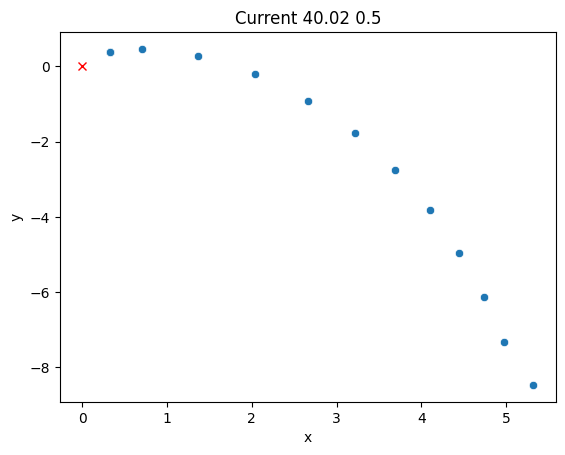

Done: [0.32155329 0.38288834]


In [118]:
env = MotorboatEnv()
agent = CurrentAgnosticAgent()
# agent = OptimalMotorboatAgent()

observation = env.reset()
trace = []
trace.append(env.boat_position.tolist())
for i in range(50):
    # action = env.action_space.sample()
    action = agent.act(observation)
    observation, reward, done, truncated, info = env.step(action)
    trace.append(env.boat_position.tolist())
    
    # draw
    clear_output(wait=True)
    df = pd.DataFrame(trace, columns=['x', 'y'])
    sns.scatterplot(data=df, x='x', y='y')
    target_x, target_y = observation[2], observation[3]
    plt.plot(target_x, target_y, marker='x', color='r')
    plt.title(f'Current {round(env.current_heading, 2)} {env.current_strength}')
    plt.show()

    if done:
        print('Done:', env.boat_position)
        break

In [129]:
def trace_agent(env_class, agent_class):
    env = env_class()
    agent = agent_class()
    s1 = env.reset()
    done = False
    trace = []
    cum_reward = 0
    while not done:
        a = agent.act(s1)
        s2, r, done, _, _ = env.step(a)
        sars = (s1, a, r, s2)
        trace.append(sars)   
        cum_reward += r
    return trace, cum_reward

In [155]:
episodes = [
    trace_agent(MotorboatEnv, CurrentAgnosticAgent)
    for _ in range(10) 
]
sars1 = episodes[0][0]
rew1 = episodes[0][1]
rew1

-5159.814945612028